In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders
!pip install imbalanced-learn
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.5 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler


# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#**Read Data**



In [4]:
filepath = '/content/drive/MyDrive/Colab_Notebooks'

#read data
original = pd.read_csv(os.path.join(filepath, 'kindey stone urine analysis.csv'))
df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])#remove the index column of df_train
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])#remove the index column of df_test

#['is_generated'] column is used to keep track of original and data that getting generate from original
original['is_generated'] = 0
df_train['is_generated'] = 1
df_test['is_generated'] = 1

#explain below
original = original.reset_index()
original['id'] = original['index'] + df_test.index[-1] + 1
original = original.drop(columns = ['index']).set_index('id')

#create target_col = target in all 3 pd.dataframe
target_col = 'target'



**Code explain:**
*   1. reset index to make sure it from 0 to the length of original pd.dataframe
*   2. create column[id] in original = original[index] + test[index[-1]+1]
*   3. drop original[index] replace it with [id]


**The reason behind this block of code line by line:**
* df_train id từ 1 đến 413

* df_test id từ 414 đến 689

* original id từ 690 đến 768 (689 + 79) vì original có 79 hàng


# **Plot and Analysis**

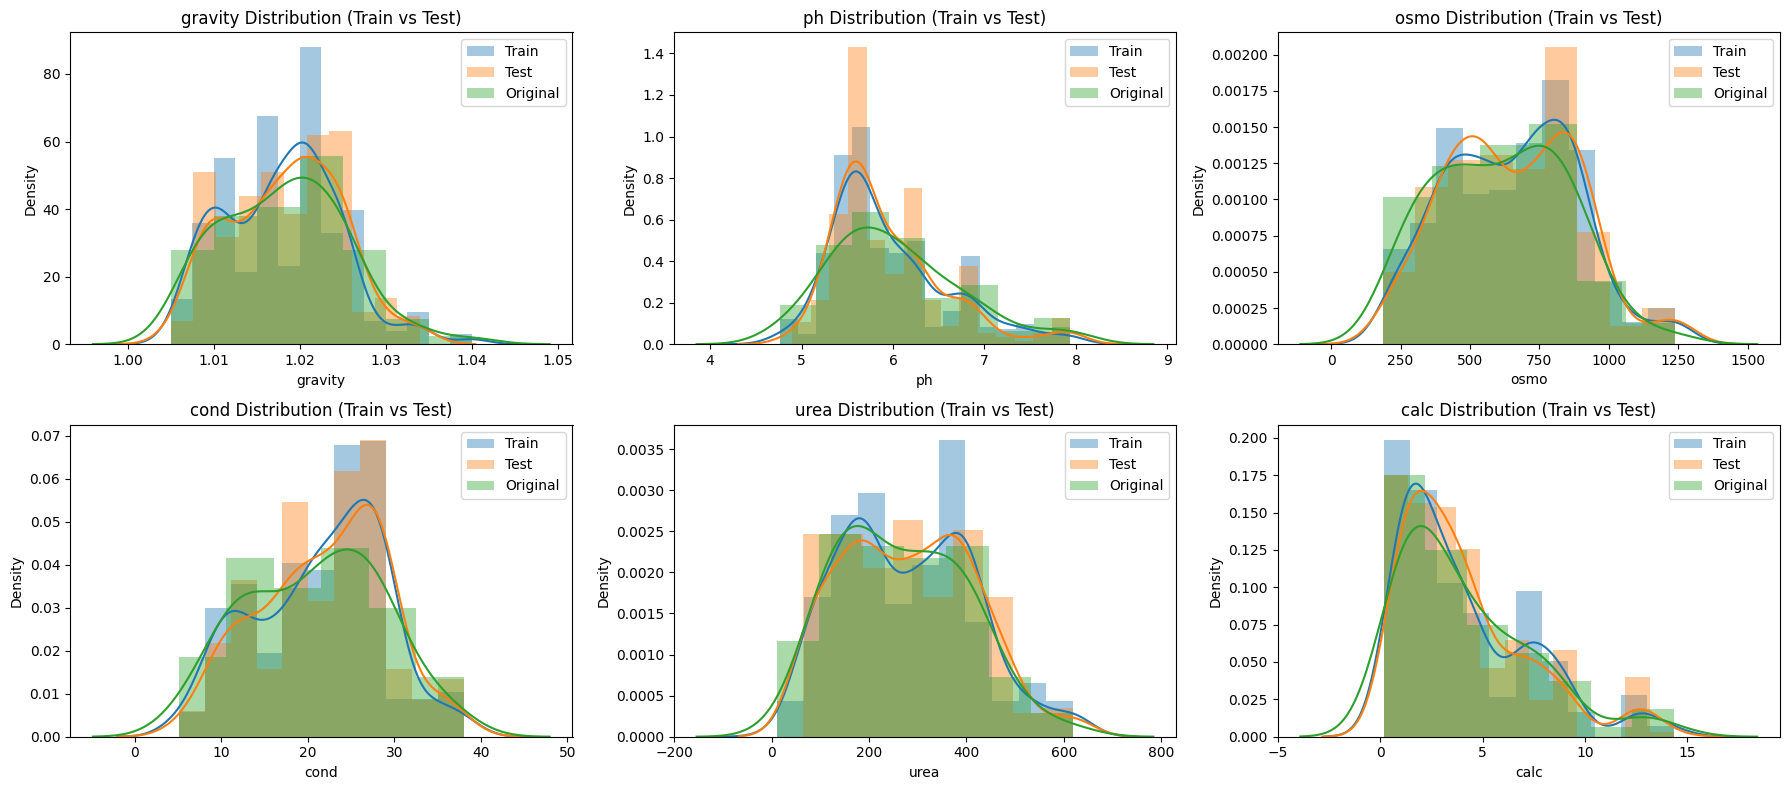

In [5]:
n_cols = 3
n_rows = (len(df_test.columns) - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))

for i, var_name in enumerate(df_test.columns.tolist()):
  if var_name != 'is_generated':
    row = i // n_cols
    col = i % n_cols

    ax = axes[row, col]
    sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
    sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
    sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
    ax.set_title(f'{var_name} Distribution (Train vs Test)')
    ax.legend()

plt.tight_layout()
plt.show()

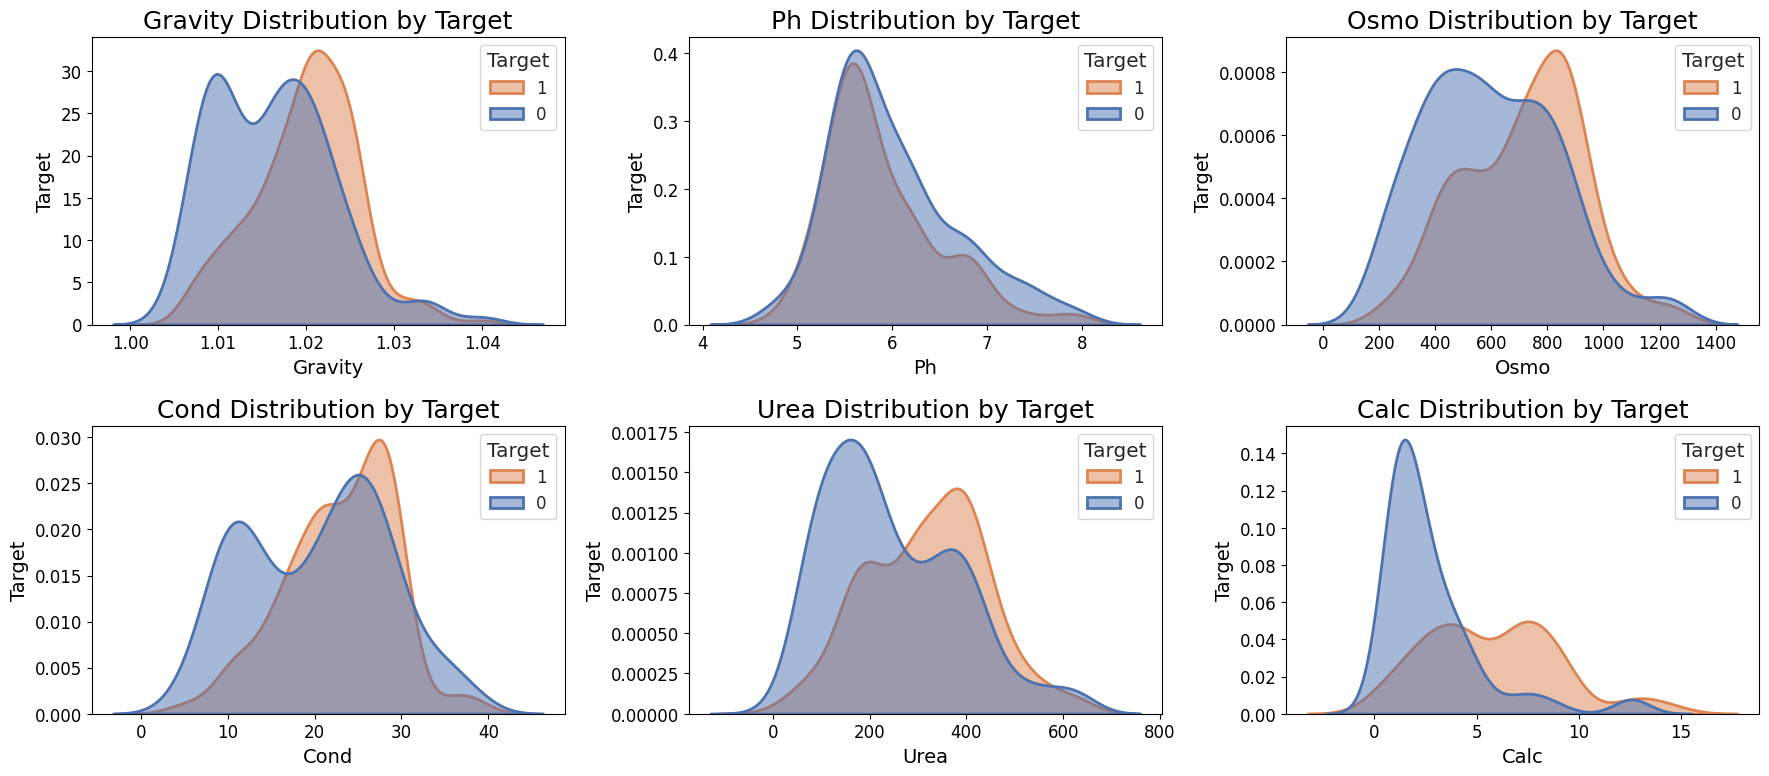

In [6]:
num_cols = 3
num_rows = (len(df_test.columns) - 1) // num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
sns.set(font_scale=1.2, style='whitegrid')

for i, col_name in enumerate(df_test.columns):
    if col_name != 'is_generated':
        ax = axes[i // num_cols, i % num_cols]
        sns.kdeplot(data=df_train, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)
        # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

        ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=18)
        ax.set_xlabel(col_name.title(), fontsize=14)
        ax.set_ylabel(target_col.title(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend([1, 0], title=target_col.title(), fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
def plot_scatter_matrix(df, target_col, drop_cols=[], size=30):
    # sns.pairplot()

    sns.set_style('whitegrid')
    cols = df.columns.drop([target_col] + drop_cols)
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(size, size), sharex=False, sharey=False)

    for i, col in enumerate(cols):
        for j, col_ in enumerate(cols):
            axes[i,j].set_xlabel(f'{col}', fontsize=14)
            axes[i,j].set_ylabel(f'{col_}', fontsize=14)

            # Plot the scatterplot
            sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=axes[i,j],
                            s=80, edgecolor='gray', alpha=0.5, palette='bright')

            axes[i,j].tick_params(axis='both', which='major', labelsize=12)

            if i == 0:
                axes[i,j].set_title(f'{col_}', fontsize=18)
            if j == 0:
                axes[i,j].set_ylabel(f'{col}', fontsize=18)

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.legend(loc='upper right', ncol=5, fontsize=18)
    plt.show()


plot_scatter_matrix(df_train, target_col, drop_cols=['is_generated'])

Output hidden; open in https://colab.research.google.com to view.

<Axes: >

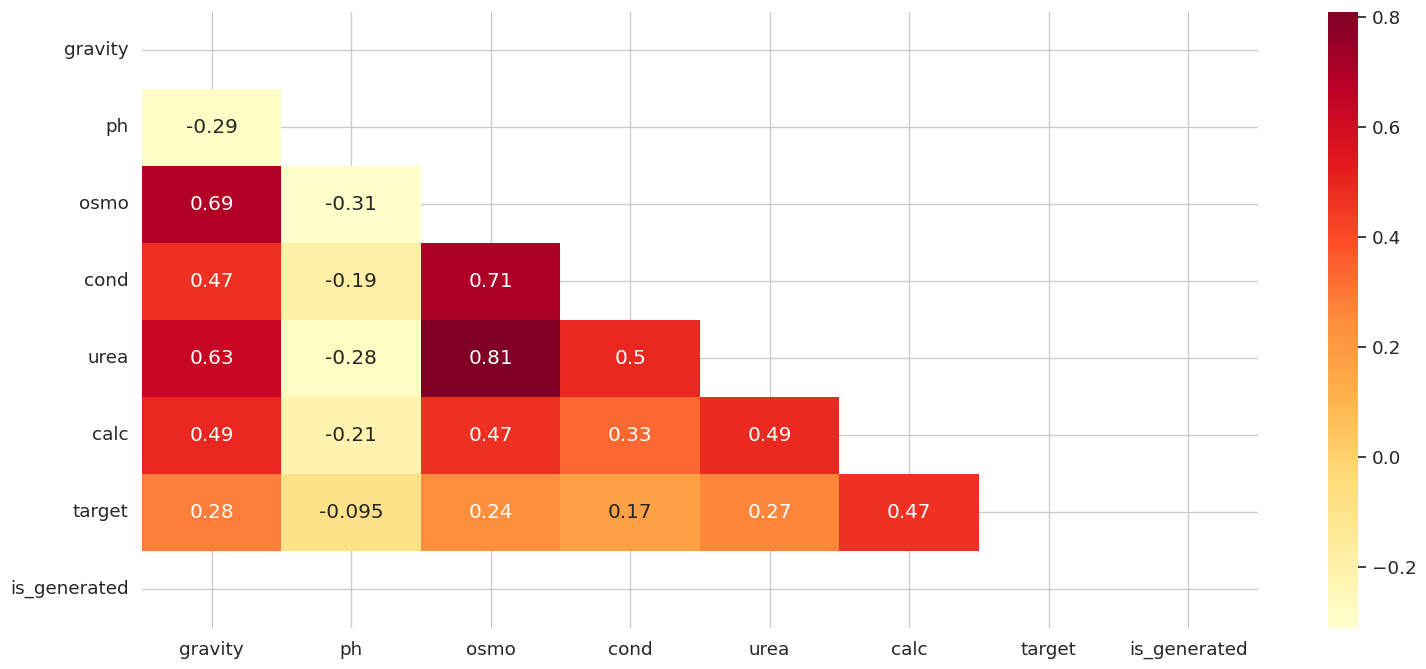

In [8]:
plt.figure(figsize=(18, 8))
mask = np.triu(np.ones_like(df_train.corr()))
sns.heatmap(df_train.corr(),cmap='YlOrRd',annot=True,mask=mask)

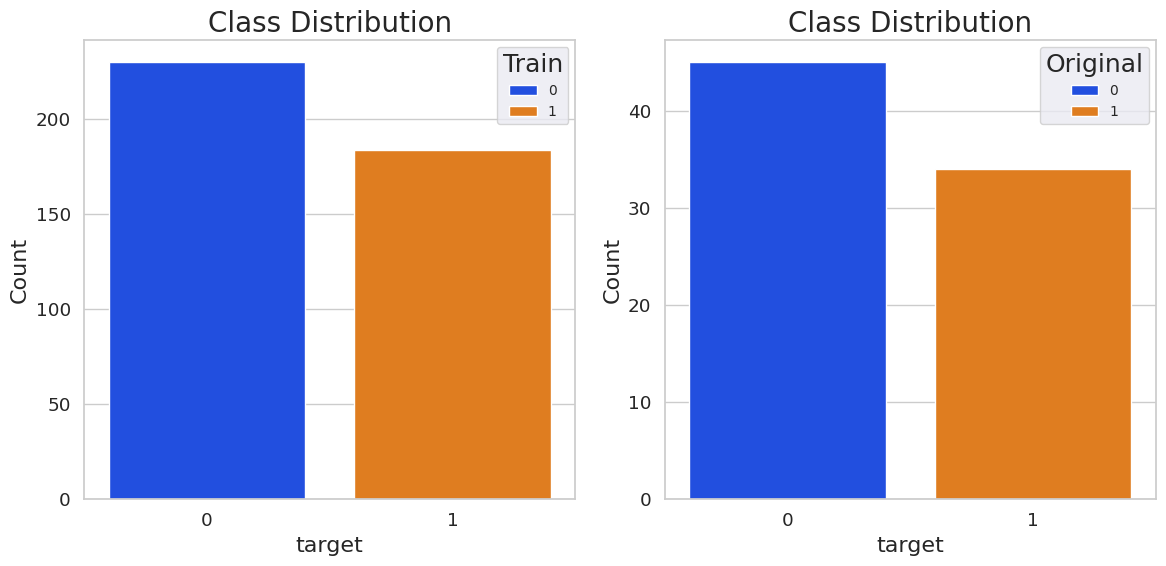

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.set(font_scale=1.5)

for i, (title, df) in enumerate(zip(['Train', 'Original'], [df_train, original])):
    classes = df[target_col].value_counts()
    class_names = classes.index
    class_counts = classes.values

    ax = sns.barplot(x=class_names, y=class_counts, hue=class_names, palette='bright', ax=axes[i], legend=True)
    ax.set_xlabel(target_col, fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Class Distribution', fontsize=20)
    ax.legend(title=title, fontsize=10)


plt.tight_layout()
plt.show()


# **Transform Data Base On The Science Of Medical**

In [10]:
def create_new_features(data):
    # Ion product of calcium and urea
    data["ion_product"] = data["calc"] * data["urea"]

    # Calcium-to-urea ratio
    data["calcium_to_urea_ratio"] = data["calc"] / data["urea"]

    # Electrolyte balance
    data["electrolyte_balance"] = data["cond"] / (10 ** (-data["ph"]))

    # Osmolality-to-specific gravity ratio
    data["osmolality_to_sg_ratio"] = data["osmo"] / data["gravity"]

    ## Add Feature engineering part
    # The product of osmolarity and density is created as a new property
    data['osmo_density'] = data['osmo'] * data['gravity']

    # Converting pH column to categorical variable

    # Deleting columns using dummy variables.
    data.drop(['ph'], axis=1, inplace=True)

    return data

In [11]:
# Concatenate train and original dataframes, and prepare train and test sets
df_train = pd.concat([df_train, original])
X_train = df_train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = df_train[f'{target_col}'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

# Create Feature
X_train = create_new_features(X_train)
X_test = create_new_features(X_test)

# StandardScaler
categorical_columns = ['is_generated', 'acidic']
numeric_columns = [_ for _ in X_train.columns if _ not in categorical_columns]
sc = StandardScaler()
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

# Delete the train and test dataframes to free up memory
del df_train, df_test

X_train shape :(493, 11) , y_train shape :(493,)
X_test shape :(276, 11)


In [12]:
X_train.head()

gravity      osmo      cond      urea      calc  is_generated  \
0 -0.729733 -0.860744 -0.863459 -1.127468 -0.829285             1   
1  1.046851  0.245256  0.298749  0.866173  0.019100             1   
2 -1.321927 -1.167021  0.417612 -0.869033  1.529411             1   
3  0.454656 -0.864998 -0.071044  0.895708  0.780470             1   
4  0.454656  0.972664 -0.467251  0.799718 -0.593105             1   

   ion_product  calcium_to_urea_ratio  electrolyte_balance  \
0    -0.811730              -0.348577            -0.231793   
1     0.202748              -0.436926            -0.287836   
2     0.057842               3.330822            -0.198397   
3     0.888568               0.055908            -0.301809   
4    -0.347715              -0.833600            -0.287495   

   osmolality_to_sg_ratio  osmo_density  
0               -0.858160     -0.863078  
1                0.232315      0.257805  
2               -1.163639     -1.169962  
3               -0.877492     -0.852674  
4                0.978943      0.966166

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['gravity'].plot(kind='hist', bins=20, title='gravity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['osmo'].plot(kind='hist', bins=20, title='osmo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['cond'].plot(kind='hist', bins=20, title='cond')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='gravity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='gravity', y='osmo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='osmo', y='cond', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='cond', y='urea', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['gravity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('gravity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['osmo']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('osmo')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cond']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cond')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['urea']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('urea')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['gravity'].plot(kind='line', figsize=(8, 4), title='gravity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['osmo'].plot(kind='line', figsize=(8, 4), title='osmo')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['cond'].plot(kind='line', figsize=(8, 4), title='cond')
plt.gca().spines[['top', 'right']].set_visible(False)

In [13]:
y_train.head()

0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64

In [14]:
X_test.head()

gravity      osmo      cond      urea      calc  is_generated  \
0 -0.137538 -1.277621 -1.299287 -0.920720 -0.919406             1   
1  0.306608  0.972664  1.011923  0.799718 -0.204650             1   
2  0.898802  0.223987 -0.242734  0.570818  2.760034             1   
3  0.306608  0.096372  0.523267 -0.182335 -0.204650             1   
4 -1.025830 -0.333267  1.011923  1.331356 -0.546490             1   

   ion_product  calcium_to_urea_ratio  electrolyte_balance  \
0    -0.814137              -0.679512            -0.300794   
1    -0.014942              -0.569082            -0.261612   
2     2.246115               1.690623            -0.292653   
3    -0.333146              -0.182651            -0.289547   
4    -0.190287              -0.880540            -0.236491   

   osmolality_to_sg_ratio  osmo_density  
0               -1.288499     -1.266762  
1                0.982626      0.962562  
2                0.213830      0.233792  
3                0.096513      0.096094  
4               -0.316228     -0.349770